In [12]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [6]:
copx =  yf.Ticker("COPX").history(period="max", interval="1d")# yf.Ticker("COPX").history(period="1y", interval="1h")

In [7]:
copx

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2010-04-20 00:00:00-04:00,33.153602,33.153602,32.597333,32.664085,1933,0.0,0.0,0.0
2010-04-21 00:00:00-04:00,32.486071,32.708578,32.063307,32.152309,2900,0.0,0.0,0.0
2010-04-22 00:00:00-04:00,32.018808,32.018808,31.529292,31.974308,3600,0.0,0.0,0.0
2010-04-23 00:00:00-04:00,31.863049,32.085556,31.707295,32.085556,1100,0.0,0.0,0.0
2010-04-26 00:00:00-04:00,33.287091,33.287091,32.041050,32.575066,3600,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-11-15 00:00:00-05:00,41.590000,41.799999,41.049999,41.099998,1825300,0.0,0.0,0.0
2024-11-18 00:00:00-05:00,41.200001,42.209999,41.169998,42.180000,1194200,0.0,0.0,0.0
2024-11-19 00:00:00-05:00,42.119999,42.959999,41.970001,42.900002,1055400,0.0,0.0,0.0


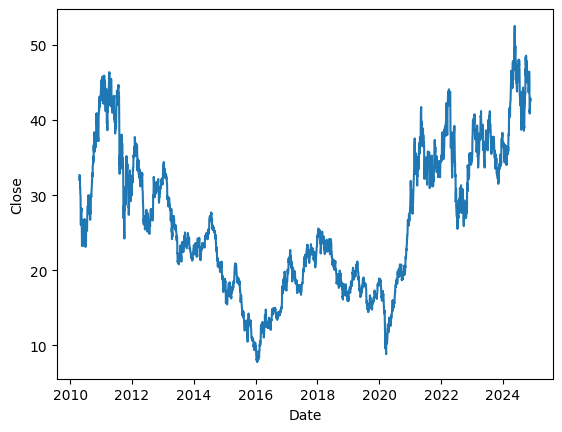

In [13]:
sns.lineplot(data=copx, x="Date", y="Close")
plt.show()

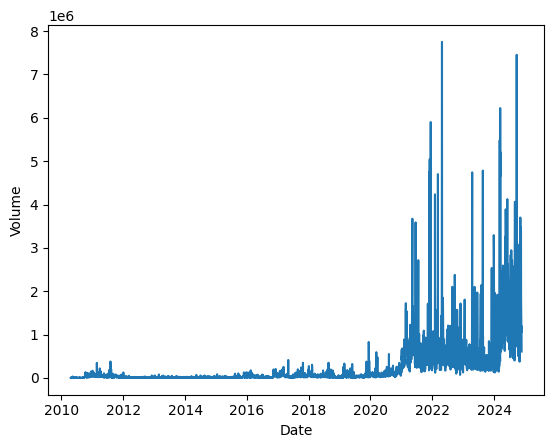

In [15]:
sns.lineplot(data=copx, x="Date", y="Volume")
plt.show()